In [3]:
import os
import time
import scipy
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from threading import Thread
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

This code defines a DataExtractor class that processes image data for machine learning. 
It initializes lists for benign and malignant images, and launches threads to process images concurrently. 
Images are resized, denoised, and normalized. Threading is used for parallel processing, enhancing performance when handling large datasets.

In [4]:
class DataExtractor:
    def __init__(self, mode):
        self._benign = []
        self._malignant = []
        self._threads = []
        if mode == 0:
            self.extract("Train/Benign/", 0)
            self.extract("Train/Malignant/", 1)
            
        elif mode == 1:
            self.extract("Test/Benign/", 0)
            self.extract("Test/Malignant/", 1)
        
    def extract_helper(self, image_file, folder, label):
        image_path = os.path.join(folder, image_file)
        img = Image.open(image_path)
        
        # resize and interpolate with Bicubic method
        img = img.resize((64, 64), Image.BICUBIC)
        # image denoising
        img = img.filter(ImageFilter.BLUR)
        img = img.filter(ImageFilter.MinFilter(3))
        img = img.filter(ImageFilter.MinFilter)

        if label == 0:
            self._benign.append(np.array(img)/255.0)
        else:
            self._malignant.append(np.array(img)/255.0)

    def extract(self, folder, label):
        image_files = os.listdir(folder)
        for image_file in image_files:
            t = Thread(target = self.extract_helper, args = (image_file, folder, label ))
            self._threads.append(t)
            t.start()
        for t in self._threads:
            t.join()

The DataManager class manages image data extracted by DataExtractor, facilitates data augmentation, and converts data into TensorFlow tensors for machine learning. It utilizes threads to parallelize the augmentation process, enhancing efficiency, but lacks exception handling and may pose memory challenges with large datasets.

In [5]:
class DataManager:
    def __init__(self, mode):
        self._dataExtractor = DataExtractor(mode)
        self._benign, self._malignant = self._dataExtractor._benign, self._dataExtractor._malignant
        self._threads = []
        #self.augmentMain(5)
        
    def returnAsTensor(self,batchSize):
        dataConcat = (self._benign + self._malignant, [0] * len(self._benign) + [1] * len(self._malignant))
        return tf.data.Dataset.from_tensor_slices(dataConcat).batch(batchSize)
        
    def augmentMain(self, augmentation_factor):
        dataGenerator = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest')
        threads_num = 0
        for img in self._benign:
            t1 = Thread(target = self.augmentBenign, args = (img, dataGenerator))
            self._threads.append(t1)
            t1.start()
        threads_num = 0
        for img in self._malignant:
            t2 = Thread(target = self.augmentMalignant, args = (img, dataGenerator))
            self._threads.append(t2)
            t2.start()
            
        for t in self._threads:
            t.join()
    def augmentBenign(self, img, dataImgGen):
        img_data = np.expand_dims(img, axis=0)
        augmented_images = dataImgGen.flow(img_data, batch_size=1)
        augmentedImage = augmented_images.next()[0]
        self._benign.append(augmentedImage)
        
    def augmentMalignant(self, img, dataImgGen):
        img_data = np.expand_dims(img, axis=0)
        augmented_images = dataImgGen.flow(img_data, batch_size=1)
        augmentedImage = augmented_images.next()[0]
        self._malignant.append(augmentedImage)   

The convModel class initializes a convolutional neural network (CNN) model for binary image classification. It defines the architecture of the model with convolutional and dense layers, compiles it with specified optimizer and loss functions, and fits it to training data while validating with testing data. The architecture includes convolutional layers for feature extraction and dense layers for classification, adhering to standard CNN principles.

In [6]:
class convModel:
    def __init__(self):
        self._className = ['Benign', 'Malignant']
        self._trainDataManager= DataManager(0)
        self._testDataManager = DataManager(1)
        
        self._trainData = self._trainDataManager.returnAsTensor(64).shuffle(12000)
        self._testData = self._testDataManager.returnAsTensor(64).shuffle(6000)
        
        self._model = keras.models.Sequential()
        self.arhitecture()
        self._model.summary()
        
        self.fittingData()
        
        
    def arhitecture(self):
        # Convolutional layers
        self._model.add(keras.layers.Conv2D(64, (2, 2), activation='relu', input_shape=(64, 64, 3)))
        self._model.add(keras.layers.MaxPooling2D((2, 2)))
        self._model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
        self._model.add(keras.layers.MaxPooling2D((2, 2)))
        self._model.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
        self._model.add(keras.layers.MaxPooling2D((2, 2)))
        self._model.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))

        # Dense layers
        self._model.add(keras.layers.Flatten())
        self._model.add(keras.layers.Dense(64, activation='relu'))
        self._model.add(keras.layers.Dense(1, activation='sigmoid'))

        self._model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                            loss=tf.keras.losses.BinaryCrossentropy(),
                            metrics=['accuracy'])
        
    def fittingData(self):
        self._model.fit(self._trainData, epochs=12, validation_data = self._testData, shuffle = True)

In [7]:
model = convModel()


2024-02-29 12:07:46.154665: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-29 12:07:46.154706: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-29 12:07:46.154714: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-29 12:07:46.155015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-29 12:07:46.155501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 63, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 128)       32896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        32832     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 64)          0

2024-02-29 12:08:11.051520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - 9s 42ms/step - loss: 0.6678 - accuracy: 0.5911 - val_loss: 0.6367 - val_accuracy: 0.5835
Epoch 2/12
186/186 [==============================] - 8s 41ms/step - loss: 0.5571 - accuracy: 0.7204 - val_loss: 0.5722 - val_accuracy: 0.6830
Epoch 3/12
186/186 [==============================] - 8s 43ms/step - loss: 0.5071 - accuracy: 0.7474 - val_loss: 0.5382 - val_accuracy: 0.7395
Epoch 4/12
186/186 [==============================] - 7s 37ms/step - loss: 0.4805 - accuracy: 0.7656 - val_loss: 0.5079 - val_accuracy: 0.7450
Epoch 5/12
186/186 [==============================] - 7s 37ms/step - loss: 0.4711 - accuracy: 0.7723 - val_loss: 0.4945 - val_accuracy: 0.7265
Epoch 6/12
186/186 [==============================] - 7s 37ms/step - loss: 0.4535 - accuracy: 0.7891 - val_loss: 0.5200 - val_accuracy: 0.7040
Epoch 7/12
186/186 [==============================] - 7s 39ms/step - loss: 0.4275 - accuracy: 0.8010 - val_loss: 0.4565 - val_accuracy: 0.8105
Epoch 8/12

In [8]:
test_loss, test_acc = model._model.evaluate(model._testData, verbose=2)
print(test_acc)

32/32 - 0s - loss: 0.3858 - accuracy: 0.8205 - 353ms/epoch - 11ms/step
0.8205000162124634


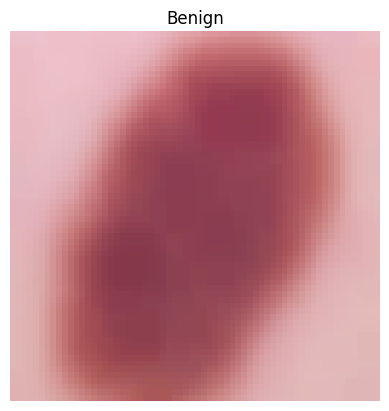

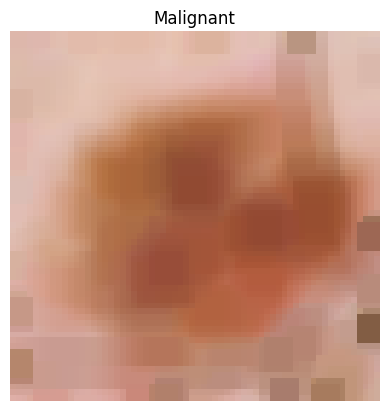

In [9]:
trainDataManager= DataManager(0)    
plt.imshow(trainDataManager._benign[0])
plt.axis('off')
plt.title("Benign")
plt.show()
plt.imshow(trainDataManager._malignant[20])
plt.axis('off')
plt.title("Malignant")
plt.show()

In [7]:
model._model.save("mymodel1")

INFO:tensorflow:Assets written to: mymodel1/assets


INFO:tensorflow:Assets written to: mymodel1/assets


The function extractor_ext reads images from a given folder, preprocesses them, extracts labels from a CSV file based on image names, and returns training data and labels. Here's a shorter description:

The function extractor_ext processes images from a folder for training. It resizes and preprocesses images, extracts labels from a CSV file based on image names, and returns the training data and labels combined.

The subsequent lines of code concatenate data and labels from two different folders, forming a larger training dataset, then evaluates the model's performance using the combined data and labels.

This approach allows for efficient training with a larger and more diverse dataset by combining images from multiple sources. However, it's important to ensure the integrity and consistency of the data across different folders and CSV files for accurate training and evaluation.

In [9]:
def extractor_ext(folder):
    _images_data1 = []
    _images_data2 = []
    dataCSV = pd.read_csv('train.csv')
    image_files = os.listdir(folder)
    for image_file in image_files:
        image_path = os.path.join(folder, image_file)
        img = Image.open(image_path)
        # resize and interpolate with Bicubic method
        img = img.resize((64, 64), Image.BICUBIC)
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # image denoising
        img = img.filter(ImageFilter.BLUR)
        img = img.filter(ImageFilter.MinFilter(3))
        img = img.filter(ImageFilter.MinFilter)

        image_name = os.path.splitext(image_file)[0]
        image_data = dataCSV[dataCSV['image_name'] == image_name]

        label = image_data['target'].values[0]
        if label == 0:
            _images_data1.append((np.array(img), label))
        else:
            _images_data2.append((np.array(img), label))
    training =  _images_data2 +  _images_data1
    training_data = list(map(lambda x: x[0], training))
    training_labels = list(map(lambda x: x[1], training))
    return training_data, training_labels
    
data, labels = extractor_ext("train_1")
data1, labels1 = extractor_ext("train_2")
data += data
labels += labels1
loss0,accuracy0 = model._model.evaluate(tf.data.Dataset.from_tensor_slices((data, labels)).batch(64), verbose=2)


518/518 - 5s - loss: 58.8088 - accuracy: 0.8578 - 5s/epoch - 10ms/step


In [10]:
print(len(data))

33126
